# О проекте

В рамках строительной компании ведётся цифровой учёт заявок на поставку бетона через Google Forms. Все заявки автоматически сохраняются в Google Таблицу, где также фиксируется информация об исполнении — фактическая дата поставки, объём, отклонения и прочие параметры. Сбор данных ведётся с июня 2024 года, и на текущий момент накоплен достаточный объём информации для проведения анализа и построения предиктивной модели.

В процессе поставок периодически возникают задержки: бетон может быть доставлен на строительную площадку с опозданием на один или несколько дней. Цель проекта — разработать модель машинного обучения, которая будет предсказывать вероятность задержки в поставке бетона.

Возможны два подхода:

* **Классификация** — модель предсказывает факт задержки (да/нет);
* **Регрессия** — модель предсказывает количество дней задержки (если она будет).

Модель позволит заранее выявлять риск отклонений от графика и своевременно принимать управленческие решения.

In [243]:
!pip install phik

In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    f1_score, 
    confusion_matrix, 
    roc_auc_score, 
    classification_report, 
    recall_score, 
    ConfusionMatrixDisplay
)

In [4]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQYF7LcaaZJQNEdQ502p8vkRTnvXn2xUHENQdTwRL2zOgM26uAgnyfgxvbzjZVE7eY0W99Somk5FhTd/pub?gid=655205162&single=true&output=csv')
df.head()

,Отметка времени,Выберите дату доставки,Укажите время доставки на объект или нажмите далее,Выберите тип строительства,Выберите объект,Выберите объект.1,Укажите конструктив,Выберите объект.2,Выберите конструкцию,Выберите объект.3,...,Укажите необходимый объём; м3,ФИО (ответственного за приёмку бетона),Телефон (ответственного за приёмку бетона),Выберите позицию.2,Unnamed: 42,Выберите конструкцию,Выберите конструкцию.3,Unnamed: 45,Unnamed: 46,Unnamed: 47
0,06.06.2024 12:09:28,07.06.2024,8:00,Здание,NaN,NaN,NaN,NaN,NaN,СПОРТ,...,90,Адаменко О.Ю.,87771456752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06.06.2024 15:26:16,07.06.2024,9:00 Д\Т школа,Благоустройство,NaN,NaN,NaN,NaN,NaN,NaN,...,3,Нуршабаев Манат,7763030297,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06.06.2024 15:28:09,07.06.2024,08:00,Здание,NaN,NaN,NaN,NaN,NaN,СПОРТ,...,90,Адаменко О.Ю.,87771456752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06.06.2024 19:06:54,07.06.2024,9-00,Здание,NaN,NaN,NaN,NaN,NaN,Школа Нурлы Жол,...,2,Алинов К.М,87051854684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,07.06.2024 8:22:02,07.06.2024,9:00,Благоустройство,NaN,NaN,NaN,NaN,NaN,NaN,...,"2,5",Нуршабаев Манат,7763030297,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4544 entries, 0 to 4543
Data columns (total 48 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Отметка времени                                     4530 non-null   object 
 1   Выберите дату доставки                              4530 non-null   object 
 2   Укажите время доставки на объект или нажмите далее  3594 non-null   object 
 3   Выберите тип строительства                          4524 non-null   object 
 4   Выберите объект                                     355 non-null    object 
 5   Выберите объект.1                                   1169 non-null   object 
 6   Укажите конструктив                                 1510 non-null   object 
 7   Выберите объект.2                                   153 non-null    object 
 8   Выберите конструкцию                                153 non-null    object 
 9

In [6]:
df['object'] = (df['Выберите объект'].fillna('') + 
                df['Выберите объект.1'].fillna('') + 
                df['Выберите объект.2'].fillna('') +
                df['Выберите объект.3'].fillna('') +
                df['Выберите объект.4'].fillna(''))

In [7]:
df['position'] = (df['Выберите позицию'].fillna('') + 
                  df['Выберите позицию.1'].fillna('') +
                  df['Выберите позицию.2'].fillna(''))

In [8]:
df['block'] = (df['Выберите блок'].fillna('') + 
               df['Выберите блок.1'].fillna('') +
               df['Выберите блок.2'].fillna('') +
               df['Выберите блок.3'].fillna('') +
               df['Выберите блок.4'].fillna('') +
               df['Выберите блок.5'].fillna(''))

In [9]:
df['constructive'] = (df['Укажите конструктив'].fillna('') + 
               df['Выберите конструкцию'].fillna('') + 
               df['Выберите конструкцию '].fillna('') + 
               df['Выберите конструктив'].fillna('') +  
               df['Выберите конструктив.1'].fillna('') + 
               df['Выберите конструктив.2'].fillna('') + 
               df['Выберите конструктив.3'].fillna('') + 
               df['Выберите конструктив.4'].fillna('') + 
               df['Выберите конструктив.5'].fillna('') + 
               df['Выберите конструкцию.1'].fillna('') + 
               df['Выберите конструкцию.2'].fillna('') + 
               df['Выберите конструкцию.3'].fillna(''))

In [10]:
df['floor'] = (df['Выберите этаж'].fillna('') + 
               df['Выберите этаж.1'].fillna('') +
               df['Выберите этаж.2'].fillna('') +
               df['Выберите этаж.3'].fillna('') +
               df['Выберите этаж.4'].fillna('') +
               df['Выберите этаж.5'].fillna('') +
               df['Выберите этаж.6'].fillna(''))

In [11]:
df['material_class'] = (df['Выберите марку раствора'].fillna('') + 
                        df['Выберите класс бетона'].fillna(''))

In [12]:
df.columns

Index(['Отметка времени', 'Выберите дату доставки',
       'Укажите время доставки на объект или нажмите далее',
       'Выберите тип строительства', 'Выберите объект', 'Выберите объект.1',
       'Укажите конструктив', 'Выберите объект.2', 'Выберите конструкцию',
       'Выберите объект.3', 'Выберите объект.4', 'Выберите конструктив',
       'Выберите блок', 'Выберите блок.1', 'Выберите позицию',
       'Выберите позицию.1', 'Выберите блок.2', 'Выберите блок.3',
       'Выберите блок.4', 'Выберите блок.5', 'Выберите этаж',
       'Выберите этаж.1', 'Выберите этаж.2', 'Выберите этаж.3',
       'Выберите конструктив.1', 'Выберите конструктив.2',
       'Выберите конструктив.3', 'Выберите этаж.4', 'Выберите этаж.5',
       'Выберите этаж.6', 'Выберите конструктив.4', 'Выберите конструктив.5',
       'Выберите конструкцию.1', 'Выберите конструкцию.2', 'Выберите материал',
       'Выберите марку раствора', 'Выберите класс бетона',
       'Выберите подвижность бетона', 'Укажите необходимый 

In [13]:
df_filtered_columns = df.drop(columns=['Unnamed: 42', 
                                       'Unnamed: 45', 
                                       'Unnamed: 46', 
                                       'Unnamed: 47',
                                       'Выберите объект', 
                                       'Выберите объект.1',
                                       'Выберите объект.2',
                                       'Выберите объект.3',
                                       'Выберите объект.4',
                                       'Выберите блок',
                                       'Выберите блок.1',
                                       'Выберите блок.2',
                                       'Выберите блок.3',
                                       'Выберите блок.4',
                                       'Выберите блок.5',
                                       'Выберите позицию',
                                       'Выберите позицию.1',
                                       'Выберите позицию.2',
                                       'Укажите конструктив',
                                       'Выберите конструкцию',
                                       'Выберите конструкцию ',
                                       'Выберите конструктив',  
                                       'Выберите конструктив.1', 
                                       'Выберите конструктив.2', 
                                       'Выберите конструктив.3', 
                                       'Выберите конструктив.4', 
                                       'Выберите конструктив.5', 
                                       'Выберите конструкцию.1',
                                       'Выберите конструкцию.2',
                                       'Выберите конструкцию.3',
                                       'Выберите этаж',
                                       'Выберите этаж.1',
                                       'Выберите этаж.2',
                                       'Выберите этаж.3',
                                       'Выберите этаж.4',
                                       'Выберите этаж.5',
                                       'Выберите этаж.6',
                                       'Выберите марку раствора',
                                       'Выберите класс бетона'], axis=1)
df_filtered_columns.head()

,Отметка времени,Выберите дату доставки,Укажите время доставки на объект или нажмите далее,Выберите тип строительства,Выберите материал,Выберите подвижность бетона,Укажите необходимый объём; м3,ФИО (ответственного за приёмку бетона),Телефон (ответственного за приёмку бетона),object,position,block,constructive,floor,material_class
0,06.06.2024 12:09:28,07.06.2024,8:00,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25
1,06.06.2024 15:26:16,07.06.2024,9:00 Д\Т школа,Благоустройство,Бетон,П3,3,Нуршабаев Манат,7763030297,Благоустройство Школа (Нурлы Жол),,,Устройство бордюр,,В 15
2,06.06.2024 15:28:09,07.06.2024,08:00,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25 СС
3,06.06.2024 19:06:54,07.06.2024,9-00,Здание,Бетон,П4,2,Алинов К.М,87051854684,Школа Нурлы Жол,,,Световые приямки,,В 25
4,07.06.2024 8:22:02,07.06.2024,9:00,Благоустройство,Бетон,П3,"2,5",Нуршабаев Манат,7763030297,Благоустройство СПОРТ,,,Устройство бордюр,,В 15


In [14]:
df_filtered_columns = df_filtered_columns.rename(columns={
    'Отметка времени' : 'application_submission_datetime',
    'Выберите дату доставки' : 'planned_delivery_date',
    'Укажите время доставки на объект или нажмите далее' : 'planned_delivery_time',
    'Выберите тип строительства' : 'type',
    'Выберите материал' : 'material',
    'Выберите подвижность бетона' : 'mobility',
    'Укажите необходимый объём; м3' : 'volume',
    'ФИО (ответственного за приёмку бетона)' : 'full_name',
    'Телефон (ответственного за приёмку бетона)' : 'phone'
})

In [15]:
df_filtered_columns.head()

,application_submission_datetime,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class
0,06.06.2024 12:09:28,07.06.2024,8:00,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25
1,06.06.2024 15:26:16,07.06.2024,9:00 Д\Т школа,Благоустройство,Бетон,П3,3,Нуршабаев Манат,7763030297,Благоустройство Школа (Нурлы Жол),,,Устройство бордюр,,В 15
2,06.06.2024 15:28:09,07.06.2024,08:00,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25 СС
3,06.06.2024 19:06:54,07.06.2024,9-00,Здание,Бетон,П4,2,Алинов К.М,87051854684,Школа Нурлы Жол,,,Световые приямки,,В 25
4,07.06.2024 8:22:02,07.06.2024,9:00,Благоустройство,Бетон,П3,"2,5",Нуршабаев Манат,7763030297,Благоустройство СПОРТ,,,Устройство бордюр,,В 15


In [16]:
df_filtered_columns['planned_delivery_time'] = (df_filtered_columns['planned_delivery_time']
                                                .str.split(' ')
                                                .str[0])
df_filtered_columns['planned_delivery_time'] = df_filtered_columns['planned_delivery_time'].str.split('(').str[0]
df_filtered_columns['planned_delivery_time'] = df_filtered_columns['planned_delivery_time'].str.replace(r'[-=*_"]', ':', regex=True)
df_filtered_columns['planned_delivery_time'] = (df_filtered_columns['planned_delivery_time']
                                                .replace(['', '8.06.2024', '9.06.2024','Нурлы','С',
                                                          'По', '29.06.2024', '08,07,2024', 'В','Школа',
                                                          '06,08,2024', 'Комфортная', '14.08.2024',
                                                          '15.08.2024', '4.09.2024', '6.09.2024',
                                                          'Детский', 'Азимхан', 'Глубоковский',
                                                          '28,10,2024', '29.10.2024', '1.11.2024',
                                                          'Манат','НЖ3', 'Кирпичный',
                                                          '45','1,5', 'Новоявленке'], np.nan))
df_filtered_columns['planned_delivery_time'] = df_filtered_columns['planned_delivery_time'].str.replace(r'[.]', ':', regex=True)
df_filtered_columns['planned_delivery_time'] = (df_filtered_columns['planned_delivery_time']
                                                .replace({'800' : '8:00', 
                                                          '1300' : '13:00', 
                                                          'в8:00' : '8:00', 
                                                          'В8:00' : '8:00',
                                                          'в' : np.nan, 
                                                          ',9:00' : '9:00', 
                                                          '0,75' : np.nan, 
                                                          '830' : '8:30',
                                                          '111' : '11:00', 
                                                          '1400' : '14:00',
                                                          '1600' : '16:00', 
                                                          '1,3' : '13:30', 
                                                          '900' : '9:00', 
                                                          '1000' : '10:00', 
                                                          '1500' : '15:00',
                                                          '0900' : '9:00'}))

df_filtered_columns['planned_delivery_time'] = df_filtered_columns['planned_delivery_time'].str.split(r'[:,;]').str[0]
df_filtered_columns['planned_delivery_time'] = (df_filtered_columns['planned_delivery_time']
                                                .replace({'08' : '8', 
                                                          '09' : '9', 
                                                          '00' : np.nan, 
                                                          '07' : '7',
                                                          '4' : '16',
                                                          '3' : '15',
                                                          '5' : '17'}))

mode_hours = df_filtered_columns['planned_delivery_time'].mode()[0]
df_filtered_columns['planned_delivery_time'] = df_filtered_columns['planned_delivery_time'].fillna(mode_hours)

In [17]:
df_report = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQYF7LcaaZJQNEdQ502p8vkRTnvXn2xUHENQdTwRL2zOgM26uAgnyfgxvbzjZVE7eY0W99Somk5FhTd/pub?gid=61989395&single=true&output=csv')
df_report.head()

,Дата и время подачи заявки,Дата доставки бетона,Время доставки бетона,Объект,"Блок, позиция",Материал,"Марка, класс",Подвижность,"Объём, м3",ФИО (ответственного за приёмку бетона),Телефон (ответственного за приёмку бетона),Дата отгрузки,Фактический объём,Отметка о исполнении,Согласование геодезистов,Категория,Согласование энергетиков
0,06.06.2024 12:09:28,07.06.2024,8:00,СПОРТ,поз.74 8 этаж Вертикал,Бетон,В 25,П4,90,Адаменко О.Ю.,87771456752,NaN,NaN,Отменено,NaN,СМР,NaN
1,06.06.2024 15:26:16,07.06.2024,9:00 Д\Т школа,Благоустройство Школа (Нурлы Жол),NaN,Бетон,В 15,П3,3,Нуршабаев Манат,7763030297,07.06.2024,3,Исполнено,NaN,СМР,NaN
2,06.06.2024 15:28:09,07.06.2024,08:00,СПОРТ,поз.74 8 этаж Вертикал,Бетон,В 25 СС,П4,90,Адаменко О.Ю.,87771456752,09.06.2024,96,Исполнено,Согласовано,СМР,NaN
3,06.06.2024 19:06:54,07.06.2024,9-00,Школа Нурлы Жол,Световые приямки,Бетон,В 25,П4,2,Алинов К.М,87051854684,11.06.2024,"1,5",Исполнено,NaN,СМР,NaN
4,07.06.2024 8:22:02,07.06.2024,9:00,Благоустройство СПОРТ,NaN,Бетон,В 15,П3,"2,5",Нуршабаев Манат,7763030297,07.06.2024,"2,5",Исполнено,NaN,СМР,NaN


In [18]:
df_report = df_report[['Дата и время подачи заявки', 'Дата отгрузки',
                       'Отметка о исполнении', 'Фактический объём']]
df_report.head()

,Дата и время подачи заявки,Дата отгрузки,Отметка о исполнении,Фактический объём
0,06.06.2024 12:09:28,NaN,Отменено,NaN
1,06.06.2024 15:26:16,07.06.2024,Исполнено,3
2,06.06.2024 15:28:09,09.06.2024,Исполнено,96
3,06.06.2024 19:06:54,11.06.2024,Исполнено,"1,5"
4,07.06.2024 8:22:02,07.06.2024,Исполнено,"2,5"


In [19]:
df_merged = pd.merge(df_filtered_columns, df_report, 
                     left_on='application_submission_datetime',
                     right_on='Дата и время подачи заявки',
                     how='inner')
df_merged.head()

,application_submission_datetime,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,Дата и время подачи заявки,Дата отгрузки,Отметка о исполнении,Фактический объём
0,06.06.2024 12:09:28,07.06.2024,8,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25,06.06.2024 12:09:28,NaN,Отменено,NaN
1,06.06.2024 15:26:16,07.06.2024,9,Благоустройство,Бетон,П3,3,Нуршабаев Манат,7763030297,Благоустройство Школа (Нурлы Жол),,,Устройство бордюр,,В 15,06.06.2024 15:26:16,07.06.2024,Исполнено,3
2,06.06.2024 15:28:09,07.06.2024,8,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25 СС,06.06.2024 15:28:09,09.06.2024,Исполнено,96
3,06.06.2024 19:06:54,07.06.2024,9,Здание,Бетон,П4,2,Алинов К.М,87051854684,Школа Нурлы Жол,,,Световые приямки,,В 25,06.06.2024 19:06:54,11.06.2024,Исполнено,"1,5"
4,07.06.2024 8:22:02,07.06.2024,9,Благоустройство,Бетон,П3,"2,5",Нуршабаев Манат,7763030297,Благоустройство СПОРТ,,,Устройство бордюр,,В 15,07.06.2024 8:22:02,07.06.2024,Исполнено,"2,5"


In [20]:
df_merged[['application_submission_date', 'application_submission_time']] = (df_merged['application_submission_datetime']
                                                                             .str.split(' ', expand=True))
df_merged['application_submission_time'] = df_merged['application_submission_time'].str.split(':').str[0]
df_merged = df_merged.drop(columns=['application_submission_datetime', 'Дата и время подачи заявки'], axis=1)
df_merged.head()

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,Дата отгрузки,Отметка о исполнении,Фактический объём,application_submission_date,application_submission_time
0,07.06.2024,8,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25,NaN,Отменено,NaN,06.06.2024,12
1,07.06.2024,9,Благоустройство,Бетон,П3,3,Нуршабаев Манат,7763030297,Благоустройство Школа (Нурлы Жол),,,Устройство бордюр,,В 15,07.06.2024,Исполнено,3,06.06.2024,15
2,07.06.2024,8,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25 СС,09.06.2024,Исполнено,96,06.06.2024,15
3,07.06.2024,9,Здание,Бетон,П4,2,Алинов К.М,87051854684,Школа Нурлы Жол,,,Световые приямки,,В 25,11.06.2024,Исполнено,"1,5",06.06.2024,19
4,07.06.2024,9,Благоустройство,Бетон,П3,"2,5",Нуршабаев Манат,7763030297,Благоустройство СПОРТ,,,Устройство бордюр,,В 15,07.06.2024,Исполнено,"2,5",07.06.2024,8


In [21]:
df_completed = df_merged[df_merged['Отметка о исполнении'] == 'Исполнено'].drop(columns='Отметка о исполнении', axis=1)
df_completed.head()

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,Дата отгрузки,Фактический объём,application_submission_date,application_submission_time
1,07.06.2024,9,Благоустройство,Бетон,П3,3,Нуршабаев Манат,7763030297,Благоустройство Школа (Нурлы Жол),,,Устройство бордюр,,В 15,07.06.2024,3,06.06.2024,15
2,07.06.2024,8,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25 СС,09.06.2024,96,06.06.2024,15
3,07.06.2024,9,Здание,Бетон,П4,2,Алинов К.М,87051854684,Школа Нурлы Жол,,,Световые приямки,,В 25,11.06.2024,"1,5",06.06.2024,19
4,07.06.2024,9,Благоустройство,Бетон,П3,"2,5",Нуршабаев Манат,7763030297,Благоустройство СПОРТ,,,Устройство бордюр,,В 15,07.06.2024,"2,5",07.06.2024,8
5,07.06.2024,8,Здание,Бетон,П3,160,Масхут.Б,87051506578,Нурлы Жол 3,поз.64,,Вертикал,1 этаж,В 25,07.06.2024,191,07.06.2024,9


In [22]:
df_completed = df_completed.rename(columns = 
                                   {
                                       'Дата отгрузки' : 'actual_delivery_date',
                                       'Фактический объём' : 'fact_volume'
                                   })
df_completed.head()                                       

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,actual_delivery_date,fact_volume,application_submission_date,application_submission_time
1,07.06.2024,9,Благоустройство,Бетон,П3,3,Нуршабаев Манат,7763030297,Благоустройство Школа (Нурлы Жол),,,Устройство бордюр,,В 15,07.06.2024,3,06.06.2024,15
2,07.06.2024,8,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25 СС,09.06.2024,96,06.06.2024,15
3,07.06.2024,9,Здание,Бетон,П4,2,Алинов К.М,87051854684,Школа Нурлы Жол,,,Световые приямки,,В 25,11.06.2024,"1,5",06.06.2024,19
4,07.06.2024,9,Благоустройство,Бетон,П3,"2,5",Нуршабаев Манат,7763030297,Благоустройство СПОРТ,,,Устройство бордюр,,В 15,07.06.2024,"2,5",07.06.2024,8
5,07.06.2024,8,Здание,Бетон,П3,160,Масхут.Б,87051506578,Нурлы Жол 3,поз.64,,Вертикал,1 этаж,В 25,07.06.2024,191,07.06.2024,9


In [23]:
df_completed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4110 entries, 1 to 4721
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   planned_delivery_date        4110 non-null   object
 1   planned_delivery_time        4110 non-null   object
 2   type                         4102 non-null   object
 3   material                     4110 non-null   object
 4   mobility                     2644 non-null   object
 5   volume                       4110 non-null   object
 6   full_name                    4101 non-null   object
 7   phone                        4102 non-null   object
 8   object                       4110 non-null   object
 9   position                     4110 non-null   object
 10  block                        4110 non-null   object
 11  constructive                 4110 non-null   object
 12  floor                        4110 non-null   object
 13  material_class               4110 non-

In [24]:
df_completed['planned_delivery_date'] = pd.to_datetime(df_completed['planned_delivery_date'], format='%d.%m.%Y')
df_completed['actual_delivery_date'] = pd.to_datetime(df_completed['actual_delivery_date'], format='%d.%m.%Y')
df_completed['application_submission_date'] = pd.to_datetime(df_completed['application_submission_date'], format='%d.%m.%Y')
df_completed['delivery_gap_days'] = (df_completed['planned_delivery_date'] - df_completed['application_submission_date']).dt.days
df_completed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4110 entries, 1 to 4721
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   planned_delivery_date        4110 non-null   datetime64[ns]
 1   planned_delivery_time        4110 non-null   object        
 2   type                         4102 non-null   object        
 3   material                     4110 non-null   object        
 4   mobility                     2644 non-null   object        
 5   volume                       4110 non-null   object        
 6   full_name                    4101 non-null   object        
 7   phone                        4102 non-null   object        
 8   object                       4110 non-null   object        
 9   position                     4110 non-null   object        
 10  block                        4110 non-null   object        
 11  constructive                 4110 non-null   obj

In [25]:
df_completed.head()

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,actual_delivery_date,fact_volume,application_submission_date,application_submission_time,delivery_gap_days
1,2024-06-07,9,Благоустройство,Бетон,П3,3,Нуршабаев Манат,7763030297,Благоустройство Школа (Нурлы Жол),,,Устройство бордюр,,В 15,2024-06-07,3,2024-06-06,15,1
2,2024-06-07,8,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25 СС,2024-06-09,96,2024-06-06,15,1
3,2024-06-07,9,Здание,Бетон,П4,2,Алинов К.М,87051854684,Школа Нурлы Жол,,,Световые приямки,,В 25,2024-06-11,"1,5",2024-06-06,19,1
4,2024-06-07,9,Благоустройство,Бетон,П3,"2,5",Нуршабаев Манат,7763030297,Благоустройство СПОРТ,,,Устройство бордюр,,В 15,2024-06-07,"2,5",2024-06-07,8,0
5,2024-06-07,8,Здание,Бетон,П3,160,Масхут.Б,87051506578,Нурлы Жол 3,поз.64,,Вертикал,1 этаж,В 25,2024-06-07,191,2024-06-07,9,0


In [26]:
df_completed['delay_days'] = (df_completed['actual_delivery_date'] - df_completed['planned_delivery_date']).dt.days
df_completed.head()

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,actual_delivery_date,fact_volume,application_submission_date,application_submission_time,delivery_gap_days,delay_days
1,2024-06-07,9,Благоустройство,Бетон,П3,3,Нуршабаев Манат,7763030297,Благоустройство Школа (Нурлы Жол),,,Устройство бордюр,,В 15,2024-06-07,3,2024-06-06,15,1,0.0
2,2024-06-07,8,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25 СС,2024-06-09,96,2024-06-06,15,1,2.0
3,2024-06-07,9,Здание,Бетон,П4,2,Алинов К.М,87051854684,Школа Нурлы Жол,,,Световые приямки,,В 25,2024-06-11,"1,5",2024-06-06,19,1,4.0
4,2024-06-07,9,Благоустройство,Бетон,П3,"2,5",Нуршабаев Манат,7763030297,Благоустройство СПОРТ,,,Устройство бордюр,,В 15,2024-06-07,"2,5",2024-06-07,8,0,0.0
5,2024-06-07,8,Здание,Бетон,П3,160,Масхут.Б,87051506578,Нурлы Жол 3,поз.64,,Вертикал,1 этаж,В 25,2024-06-07,191,2024-06-07,9,0,0.0


In [27]:
df_completed[df_completed['type'].isna()]

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,actual_delivery_date,fact_volume,application_submission_date,application_submission_time,delivery_gap_days,delay_days
98,2024-06-30,8,NaN,Бетон,NaN,3468,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,,,,,2024-06-30,3468,2024-06-30,0,0,0.0
193,2024-07-31,8,NaN,Бетон,NaN,244,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,,,,,2024-07-31,244,2024-07-31,0,0,0.0
194,2024-07-31,8,NaN,Бетон,NaN,244,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,,,,,2024-07-31,"31,00",2024-07-31,0,0,0.0
197,2024-07-31,8,NaN,Раствор,NaN,31,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,,,,,2024-07-31,244,2024-07-31,0,0,0.0
198,2024-07-31,8,NaN,Раствор,NaN,31,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,,,,,2024-07-31,"31,00",2024-07-31,0,0,0.0
412,2024-08-31,8,NaN,Раствор,NaN,47,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,,,,,2024-08-31,"47,00",2024-08-31,0,0,0.0
733,2024-09-30,8,NaN,Раствор,NaN,33,NaN,NaN,Разница за месяц м/у эл.заявкой и отчётом бру,,,,,,2024-09-30,"33,00",2024-09-30,0,0,0.0
1008,2024-06-30,8,NaN,Раствор,NaN,397,NaN,NaN,Разница м/у эл.журналом и отчётом БРУ,,,,,,NaT,"397,00",2024-11-27,0,-150,NaN


In [28]:
df_not_null_in_type = df_completed[~df_completed['type'].isna()]
df_not_null_in_type.head()

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,actual_delivery_date,fact_volume,application_submission_date,application_submission_time,delivery_gap_days,delay_days
1,2024-06-07,9,Благоустройство,Бетон,П3,3,Нуршабаев Манат,7763030297,Благоустройство Школа (Нурлы Жол),,,Устройство бордюр,,В 15,2024-06-07,3,2024-06-06,15,1,0.0
2,2024-06-07,8,Здание,Бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25 СС,2024-06-09,96,2024-06-06,15,1,2.0
3,2024-06-07,9,Здание,Бетон,П4,2,Алинов К.М,87051854684,Школа Нурлы Жол,,,Световые приямки,,В 25,2024-06-11,"1,5",2024-06-06,19,1,4.0
4,2024-06-07,9,Благоустройство,Бетон,П3,"2,5",Нуршабаев Манат,7763030297,Благоустройство СПОРТ,,,Устройство бордюр,,В 15,2024-06-07,"2,5",2024-06-07,8,0,0.0
5,2024-06-07,8,Здание,Бетон,П3,160,Масхут.Б,87051506578,Нурлы Жол 3,поз.64,,Вертикал,1 этаж,В 25,2024-06-07,191,2024-06-07,9,0,0.0


In [29]:
df_not_null_in_type.loc[:, 'type'] = df_not_null_in_type['type'].str.lower()
df_not_null_in_type.loc[:, 'type'] = df_not_null_in_type['type'].replace('здания', 'здание')
df_not_null_in_type['type'].unique()

array(['благоустройство', 'здание', 'коммерческие объекты',
       'инженерные сети', 'производственные объекты', 'жби',
       'реализация на сторону'], dtype=object)

In [30]:
df_not_null_in_type.loc[:, 'material'] = df_not_null_in_type['material'].str.lower()
df_not_null_in_type['material'].unique()

array(['бетон', 'раствор'], dtype=object)

In [31]:
print(df_not_null_in_type['mobility'].unique())

['П3' 'П4' nan]


In [32]:
df_not_null_in_type.loc[:, 'mobility'] = df_not_null_in_type['mobility'].fillna('нет')
print(df_not_null_in_type['mobility'].unique())

['П3' 'П4' 'нет']


In [33]:
df_not_null_in_type['volume'].unique()

array(['3', '90', '2', '2,5', '160', '28', '91', '20', '14', '106', '1,5',
       '145', '103', '0,5', '115', '80', '118', '7', '4', '104', '25',
       '11', '0,7', '52', '10', '1', '97', '30', '0,8', '13', '1,2', '95',
       '98', '16,5', '6', '65', '94', '82', '34,5', '4,5', '105', '3,5',
       '92', '70', '120', '38', '5', '12,5', '105,5', '114', '169', '140',
       '6,5', '2,75', '19', '5,5', '60', '37', '15', '55', '21,5', '85',
       '8', '74', '6,75', '113', '1,75', '4,75', '27,5', '2,25', '0,25',
       '27', '168', '9', '4,25', '26,5', '11,5', '0,75', '17', '0,3',
       '69', '12', '45', '15,5', '3,25', '16', '112', '10,5', '75', '18',
       '33', '1,25', '585', '35', '560', '40', '16,7', '9,1', '8,4',
       '116', '125', '7,2', '2,2', '19,2', '32', '72', '3,75', '62',
       '88,4', '200', '24', '8,3', '155', '19,5', '180', '21', '9,5',
       '7,5', '220', '22', '2,3', '3,1', '26', '110', '61', '48', '96',
       '44', '8,5', '1,7', '1,1', '1,3', '2,7', '1,4', '31', 

In [34]:
df_not_null_in_type[df_not_null_in_type['volume'] == '3970,2']

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,actual_delivery_date,fact_volume,application_submission_date,application_submission_time,delivery_gap_days,delay_days
1738,2024-03-31,8,здание,бетон,П3,"3970,2",+++,+++,Общий за месяц,,,,,В 15,2024-03-31,"3970,2",2024-10-09,10,-192,0.0


In [35]:
df_not_null_in_type[df_not_null_in_type['object'] == 'Общий за месяц']

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,actual_delivery_date,fact_volume,application_submission_date,application_submission_time,delivery_gap_days,delay_days
1736,2024-01-31,8,здание,бетон,П3,"465,4",+++,+++,Общий за месяц,,,,,В 15,2024-01-31,"465,4",2024-10-09,10,-252,0.0
1737,2024-02-29,8,здание,бетон,П3,"382,2",+++,+++,Общий за месяц,,,,,В 15,2024-02-29,"382,2",2024-10-09,10,-223,0.0
1738,2024-03-31,8,здание,бетон,П3,"3970,2",+++,+++,Общий за месяц,,,,,В 15,2024-03-31,"3970,2",2024-10-09,10,-192,0.0
1741,2024-04-30,8,здание,бетон,П3,"10001,3",+++,+++,Общий за месяц,,,,,В 15,2024-04-30,"10001,3",2024-10-09,10,-162,0.0
1743,2024-05-31,8,здание,бетон,П3,"10264,9",+++,+++,Общий за месяц,,,,,В 15,2024-05-31,"10264,9",2024-10-09,10,-131,0.0


In [36]:
df_since_june2024 = df_not_null_in_type[df_not_null_in_type['full_name'] != '+++']
df_since_june2024.head()

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,block,constructive,floor,material_class,actual_delivery_date,fact_volume,application_submission_date,application_submission_time,delivery_gap_days,delay_days
1,2024-06-07,9,благоустройство,бетон,П3,3,Нуршабаев Манат,7763030297,Благоустройство Школа (Нурлы Жол),,,Устройство бордюр,,В 15,2024-06-07,3,2024-06-06,15,1,0.0
2,2024-06-07,8,здание,бетон,П4,90,Адаменко О.Ю.,87771456752,СПОРТ,поз.74,,Вертикал,8 этаж,В 25 СС,2024-06-09,96,2024-06-06,15,1,2.0
3,2024-06-07,9,здание,бетон,П4,2,Алинов К.М,87051854684,Школа Нурлы Жол,,,Световые приямки,,В 25,2024-06-11,"1,5",2024-06-06,19,1,4.0
4,2024-06-07,9,благоустройство,бетон,П3,"2,5",Нуршабаев Манат,7763030297,Благоустройство СПОРТ,,,Устройство бордюр,,В 15,2024-06-07,"2,5",2024-06-07,8,0,0.0
5,2024-06-07,8,здание,бетон,П3,160,Масхут.Б,87051506578,Нурлы Жол 3,поз.64,,Вертикал,1 этаж,В 25,2024-06-07,191,2024-06-07,9,0,0.0


In [37]:
df_since_june2024['volume'].unique()

array(['3', '90', '2', '2,5', '160', '28', '91', '20', '14', '106', '1,5',
       '145', '103', '0,5', '115', '80', '118', '7', '4', '104', '25',
       '11', '0,7', '52', '10', '1', '97', '30', '0,8', '13', '1,2', '95',
       '98', '16,5', '6', '65', '94', '82', '34,5', '4,5', '105', '3,5',
       '92', '70', '120', '38', '5', '12,5', '105,5', '114', '169', '140',
       '6,5', '2,75', '19', '5,5', '60', '37', '15', '55', '21,5', '85',
       '8', '74', '6,75', '113', '1,75', '4,75', '27,5', '2,25', '0,25',
       '27', '168', '9', '4,25', '26,5', '11,5', '0,75', '17', '0,3',
       '69', '12', '45', '15,5', '3,25', '16', '112', '10,5', '75', '18',
       '33', '1,25', '585', '35', '560', '40', '16,7', '9,1', '8,4',
       '116', '125', '7,2', '2,2', '19,2', '32', '72', '3,75', '62',
       '88,4', '200', '24', '8,3', '155', '19,5', '180', '21', '9,5',
       '7,5', '220', '22', '2,3', '3,1', '26', '110', '61', '48', '96',
       '44', '8,5', '1,7', '1,1', '1,3', '2,7', '1,4', '31', 

In [38]:
df_since_june2024.loc[:, 'volume'] = df_since_june2024['volume'].str.split(' ').str[0]
df_since_june2024['volume'].unique()

array(['3', '90', '2', '2,5', '160', '28', '91', '20', '14', '106', '1,5',
       '145', '103', '0,5', '115', '80', '118', '7', '4', '104', '25',
       '11', '0,7', '52', '10', '1', '97', '30', '0,8', '13', '1,2', '95',
       '98', '16,5', '6', '65', '94', '82', '34,5', '4,5', '105', '3,5',
       '92', '70', '120', '38', '5', '12,5', '105,5', '114', '169', '140',
       '6,5', '2,75', '19', '5,5', '60', '37', '15', '55', '21,5', '85',
       '8', '74', '6,75', '113', '1,75', '4,75', '27,5', '2,25', '0,25',
       '27', '168', '9', '4,25', '26,5', '11,5', '0,75', '17', '0,3',
       '69', '12', '45', '15,5', '3,25', '16', '112', '10,5', '75', '18',
       '33', '1,25', '585', '35', '560', '40', '16,7', '9,1', '8,4',
       '116', '125', '7,2', '2,2', '19,2', '32', '72', '3,75', '62',
       '88,4', '200', '24', '8,3', '155', '19,5', '180', '21', '9,5',
       '7,5', '220', '22', '2,3', '3,1', '26', '110', '61', '48', '96',
       '44', '8,5', '1,7', '1,1', '1,3', '2,7', '1,4', '31', 

In [39]:
df_since_june2024 = df_since_june2024.copy()
df_since_june2024['volume'] = df_since_june2024['volume'].str.replace(',', '.', regex=False).astype(float)
df_since_june2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4094 entries, 1 to 4721
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   planned_delivery_date        4094 non-null   datetime64[ns]
 1   planned_delivery_time        4094 non-null   object        
 2   type                         4094 non-null   object        
 3   material                     4094 non-null   object        
 4   mobility                     4094 non-null   object        
 5   volume                       4094 non-null   float64       
 6   full_name                    4093 non-null   object        
 7   phone                        4094 non-null   object        
 8   object                       4094 non-null   object        
 9   position                     4094 non-null   object        
 10  block                        4094 non-null   object        
 11  constructive                 4094 non-null   obj

In [40]:
volume_by_date = df_since_june2024.groupby('planned_delivery_date')['volume'].sum().reset_index()
volume_by_date = volume_by_date.rename(columns={'volume' : 'volume_by_date'})
df_since_june2024 = pd.merge(df_since_june2024, volume_by_date,
                             on='planned_delivery_date',
                             how='inner')
df_since_june2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4094 entries, 0 to 4093
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   planned_delivery_date        4094 non-null   datetime64[ns]
 1   planned_delivery_time        4094 non-null   object        
 2   type                         4094 non-null   object        
 3   material                     4094 non-null   object        
 4   mobility                     4094 non-null   object        
 5   volume                       4094 non-null   float64       
 6   full_name                    4093 non-null   object        
 7   phone                        4094 non-null   object        
 8   object                       4094 non-null   object        
 9   position                     4094 non-null   object        
 10  block                        4094 non-null   object        
 11  constructive                 4094 non-null 

In [41]:
print(df_since_june2024['full_name'].nunique())
print(df_since_june2024['full_name'].unique())

227
['Нуршабаев Манат' 'Адаменко О.Ю.' 'Алинов К.М' 'Масхут.Б'
 'Баяхметов Ф.Е.' 'Мусаканов А.О' 'Кабден Ринат' 'Нуксарин СО'
 'Нуксарин С О' 'Шестаков АЕ' 'Аубакиров Д.Ж.' 'Шестаков АЕ '
 'Сейтказынов Д.А.' 'Адаменко Олег' 'Юшко ' 'Баяхметов ' 'ШМАКОВ.И' 'Юшко'
 'Акылбеков Нариман' 'Баянбаев' 'Аменов Эльдар Айтжанович'
 'Рахимжанов Арман ' 'Алинов К' 'Адаменко Олень' 'Азимхан Б.Е.'
 'Баянбаев Е.Д' 'Турсынбеков Х.Г. ' 'Киселев Д.В.' 'Абдрахманов Е.Т.'
 'Азимхан Б.Е' 'Кабдиев М' 'Оразбеков Е.К' 'Грибченко.Е.И' 'Шестаков '
 'Шматов Д.П.' 'Азимхан Б,Е' 'Грибченко Е.И.' 'Грибченко Е.И' 'Баяхметов'
 'Юшко С.В.' 'Дүйсен Ільяс Ержанұлы' 'Юшко. С.В' 'Грибченко Е.И '
 'Юшко.С.В' 'Абдрахманов Д.К' 'Акимбеков Р.С' 'Ерболатов ' 'Сагадиев.А.Р'
 'Кабден Р' 'Маутбеков' 'Титаренко Кирилл Владимирович' 'Юшко С.В'
 'Каширский Никита Сергеевич' 'Маутбеков С' 'Юшко.С.В.' 'Масалимов Айбек'
 'Акимбеков Р.С.' 'Масалимов' 'Юшко.С' 'Макажанов Е.С' 'Титаренко Кирилл'
 'Макажанов Е.С.' 'Алимжанов Куантай Болатов

In [42]:
print(df_since_june2024['full_name'].nunique())
print(df_since_june2024['full_name'].unique())

227
['Нуршабаев Манат' 'Адаменко О.Ю.' 'Алинов К.М' 'Масхут.Б'
 'Баяхметов Ф.Е.' 'Мусаканов А.О' 'Кабден Ринат' 'Нуксарин СО'
 'Нуксарин С О' 'Шестаков АЕ' 'Аубакиров Д.Ж.' 'Шестаков АЕ '
 'Сейтказынов Д.А.' 'Адаменко Олег' 'Юшко ' 'Баяхметов ' 'ШМАКОВ.И' 'Юшко'
 'Акылбеков Нариман' 'Баянбаев' 'Аменов Эльдар Айтжанович'
 'Рахимжанов Арман ' 'Алинов К' 'Адаменко Олень' 'Азимхан Б.Е.'
 'Баянбаев Е.Д' 'Турсынбеков Х.Г. ' 'Киселев Д.В.' 'Абдрахманов Е.Т.'
 'Азимхан Б.Е' 'Кабдиев М' 'Оразбеков Е.К' 'Грибченко.Е.И' 'Шестаков '
 'Шматов Д.П.' 'Азимхан Б,Е' 'Грибченко Е.И.' 'Грибченко Е.И' 'Баяхметов'
 'Юшко С.В.' 'Дүйсен Ільяс Ержанұлы' 'Юшко. С.В' 'Грибченко Е.И '
 'Юшко.С.В' 'Абдрахманов Д.К' 'Акимбеков Р.С' 'Ерболатов ' 'Сагадиев.А.Р'
 'Кабден Р' 'Маутбеков' 'Титаренко Кирилл Владимирович' 'Юшко С.В'
 'Каширский Никита Сергеевич' 'Маутбеков С' 'Юшко.С.В.' 'Масалимов Айбек'
 'Акимбеков Р.С.' 'Масалимов' 'Юшко.С' 'Макажанов Е.С' 'Титаренко Кирилл'
 'Макажанов Е.С.' 'Алимжанов Куантай Болатов

In [43]:
df_since_june2024['full_name'] = df_since_june2024['full_name'].str.lower()
df_since_june2024['full_name'] = df_since_june2024['full_name'].str.strip()
df_since_june2024['full_name'] = df_since_june2024['full_name'].str.split(' ').str[0]
df_since_june2024['full_name'] = np.where(df_since_june2024['type'] == 'реализация на сторону', 
                                          np.nan,
                                          df_since_june2024['full_name'])
df_since_june2024['full_name'] = df_since_june2024['full_name'].fillna('на сторону')
df_since_june2024['full_name'] = df_since_june2024['full_name'].str.split(r'[.,]').str[0]
print(df_since_june2024['full_name'].nunique())
sorted(list(df_since_june2024['full_name'].unique()))

81


['cаматов',
 'абдрахманов',
 'абылов',
 'адаменко',
 'азимхан',
 'акимбеков',
 'акылбеков',
 'алимжанов',
 'алинов',
 'алланиязов',
 'аменов',
 'амренов',
 'аубакиров',
 'аяпбергенов',
 'ақылбеков',
 'баянбаев',
 'баяхметов',
 'бейсембинов',
 'белоусов',
 'бимаканов',
 'бру',
 'габдиев',
 'грибченко',
 'дешин',
 'дүйсен',
 'енсебаев',
 'ерболатов',
 'жакежанов',
 'жаксылыков',
 'жаманов',
 'жотабаев',
 'кабден',
 'кабдиев',
 'камалов',
 'каширский',
 'кизатулин',
 'киселев',
 'куатбеков',
 'лебедев',
 'макажанов',
 'манат',
 'масалимов',
 'масхут',
 'маутбеков',
 'мейрам',
 'муктаров',
 'муратханов',
 'мусаканов',
 'мусин',
 'мырзахметов',
 'на сторону',
 'нуксарин',
 'нурахметов',
 'нуршабаев',
 'оразбеков',
 'пайзрахманов',
 'раимханов',
 'рахимжанов',
 'сагадиев',
 'салангин',
 'саматов',
 'саметаев',
 'сарсекеев',
 'сейтказынов',
 'сериков',
 'танабаев',
 'титаренко',
 'титоренко',
 'токтаров',
 'тоқтаров',
 'тоқтарханов',
 'тоқтасынов',
 'туркестанов',
 'турсынбеков',
 'тілеуқанов

In [44]:
df_since_june2024['object'] = (
    df_since_june2024['object']
    .str.lower()
    .str.strip()
    .str.replace(r'\s*-\s*', '-', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
)
print(df_since_june2024['object'].nunique())
sorted(list(df_since_june2024['object'].unique()))

109


['',
 '4 бру',
 'brick town',
 'brick town 2',
 'royal b',
 'абк',
 'абк ново-явленка',
 'абк ново-явленка база',
 'абк(ново-явленка',
 'абк(ново-явленка)',
 'автомойка (сатпаева 82а)',
 'автомойка ул. сатпаева 82а',
 'автомока ул. сатпаева 82 а',
 'асфальтозавод (новоявленка)',
 'атц победы',
 'база ново-явленка. абз',
 'база эскор',
 'базовавя 5 тупик',
 'базовая 5',
 'базовая 5 (тупик)',
 'базовая, 3',
 'базовая, 3 магазин автозапчастей',
 'бизнес-центр',
 'бизнесцентр',
 'благоустройства бру',
 'благоустройство 12-16 этажки',
 'благоустройство brick town',
 'благоустройство комфортная школа (самрук)',
 'благоустройство нурлы жол 1,2',
 'благоустройство нурлы жол 3',
 'благоустройство спорт',
 'благоустройство школа (нурлы жол)',
 'бру',
 'бру 4',
 'бру жансат',
 'бру на растворный узел',
 'бру парковка',
 'бру под силос',
 'бру столовая',
 'гараж',
 'гараж (на комсомольском)',
 'гимназия(колледж)',
 'глубоковский кирзавод',
 'глубоковский кирзавод (складпод глину)',
 'горная ульбин

In [45]:
print(df_since_june2024['object'].value_counts().to_string())

object
нурлы жол 3                                                                                898
жби                                                                                        508
спорт                                                                                      417
brick town                                                                                 304
комфортная школа                                                                           298
royal b                                                                                    160
благоустройство brick town                                                                 117
орлёнок                                                                                    106
благоустройство нурлы жол 3                                                                106
центральная база (сам.ш.29)                                                                 98
благоустройство комфортная школа (самрук)  

In [46]:
df_since_june2024['object'] = df_since_june2024['object'].replace(
    ['жби-2', 'жби -2','жби цех','жби 2', 'жби,цех брусчатки,', 
     'цех брусчатки (базовая 5)', 'цех жби бозовая 5',
     'цех тротуарной плитки'], 'жби')
df_since_june2024['object'] = df_since_june2024['object'].replace(
    ['эко полис под башенный кран', 'эко полюс под кран подбетонка','паркинг'], 'экополис')
df_since_june2024['object'] = df_since_june2024['object'].replace(
     ['тц победы', 'бизнес-центр','бизнесцентр'], 'Бизнес центр пр.Победы')
print(df_since_june2024['object'].value_counts().to_string())

object
нурлы жол 3                                                                                898
жби                                                                                        580
спорт                                                                                      417
brick town                                                                                 304
комфортная школа                                                                           298
royal b                                                                                    160
благоустройство brick town                                                                 117
орлёнок                                                                                    106
благоустройство нурлы жол 3                                                                106
центральная база (сам.ш.29)                                                                 98
благоустройство комфортная школа (самрук)  

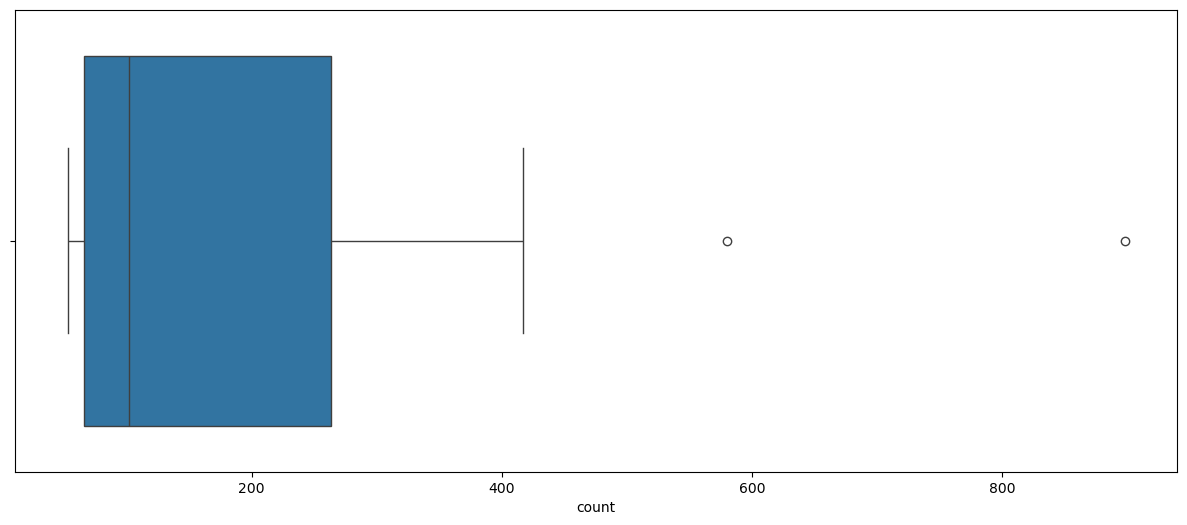

In [47]:
for_boxplot = df_since_june2024['object'].value_counts().reset_index()
for_boxplot.columns = ['object', 'count']
plt.figure(figsize=(15,6))
sns.boxplot(for_boxplot[for_boxplot['count'] > 50], x='count')
plt.show()

In [48]:
objects = [
    'brick town',
    'brick town 2',
    'royal b',
    'автомойка атх',
    'автомойка (нурлы жол)',
    'асфальтозавод (новоявленка)',
    'база эскор',
    'благоустройство 12-16 этажки',
    'благоустройство brick town',
    'благоустройство нурлы жол 1,2',
    'благоустройство нурлы жол 3',
    'благоустройство спорт',
    'благоустройство школа (нурлы жол)',
    'благоустройство комфортная школа (самрук)',
    'дробилка (новоявленка)',
    'жби',
    'инженерные сети 12-16-этажки',
    'инженерные сети брик таун',
    'инженерные сети поз. 107',
    'инженерные сети  школа (нурлы жол)',
    'инженерные сети комфортная школа (самрук)',
    'инженерные сети школа нурлы жол',
    'каменный карьер',
    'кафе бистро',
    'квартальные инженерные сети теплоснабжения, водоснабжения и водоотведения (нурлы жол 1-2)',
    'квартальные инженерные сети теплоснабжения, водоснабжения и водоотведения (нурлы жол 3)',
    'квартальные инженерные сети теплоснабжения, водоснабжения и водоотведения (спорт)',
    'коллектор',
    'комфортная школа',
    'кос',
    'кренделия',
    'ледовый каток',
    'магазин автозапчастей (эскор)',
    'металлоцех (новое строительство)',
    'мост (новоявленка)',
    'нурлы жол 3',
    'орлёнок',
    'очистные сооружения',
    'пропарочная камера',
    'спорт',
    'транспортная развязка на пересечении пр. сатпаева и ул. жибек жолы',
    'транспортная развязка на пересечении пр. сатпаева и ул. жибек жолы',
    'центральная база (сам.ш.29)',
    'центральный склад (новое строительство)',
    'экополис' 
]

In [49]:
df_since_june2024['object'] = df_since_june2024['object'].apply(lambda x: x if x in objects else 'другой')
print(df_since_june2024['object'].value_counts().to_string())

object
нурлы жол 3                                                                                898
жби                                                                                        580
спорт                                                                                      417
brick town                                                                                 304
комфортная школа                                                                           298
другой                                                                                     263
royal b                                                                                    160
благоустройство brick town                                                                 117
орлёнок                                                                                    106
благоустройство нурлы жол 3                                                                106
центральная база (сам.ш.29)                

In [50]:
df_since_june2024.head()

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,...,constructive,floor,material_class,actual_delivery_date,fact_volume,application_submission_date,application_submission_time,delivery_gap_days,delay_days,volume_by_date
0,2024-06-07,9,благоустройство,бетон,П3,3.0,нуршабаев,7763030297,благоустройство школа (нурлы жол),,...,Устройство бордюр,,В 15,2024-06-07,3,2024-06-06,15,1,0.0,288.0
1,2024-06-07,8,здание,бетон,П4,90.0,адаменко,87771456752,спорт,поз.74,...,Вертикал,8 этаж,В 25 СС,2024-06-09,96,2024-06-06,15,1,2.0,288.0
2,2024-06-07,9,здание,бетон,П4,2.0,алинов,87051854684,другой,,...,Световые приямки,,В 25,2024-06-11,"1,5",2024-06-06,19,1,4.0,288.0
3,2024-06-07,9,благоустройство,бетон,П3,2.5,нуршабаев,7763030297,благоустройство спорт,,...,Устройство бордюр,,В 15,2024-06-07,"2,5",2024-06-07,8,0,0.0,288.0
4,2024-06-07,8,здание,бетон,П3,160.0,масхут,87051506578,нурлы жол 3,поз.64,...,Вертикал,1 этаж,В 25,2024-06-07,191,2024-06-07,9,0,0.0,288.0


In [51]:
df_since_june2024['delay'] =  df_since_june2024['delay_days'].apply(lambda x: 0 if x == 0 else 1)
df_since_june2024.head()

,planned_delivery_date,planned_delivery_time,type,material,mobility,volume,full_name,phone,object,position,...,floor,material_class,actual_delivery_date,fact_volume,application_submission_date,application_submission_time,delivery_gap_days,delay_days,volume_by_date,delay
0,2024-06-07,9,благоустройство,бетон,П3,3.0,нуршабаев,7763030297,благоустройство школа (нурлы жол),,...,,В 15,2024-06-07,3,2024-06-06,15,1,0.0,288.0,0
1,2024-06-07,8,здание,бетон,П4,90.0,адаменко,87771456752,спорт,поз.74,...,8 этаж,В 25 СС,2024-06-09,96,2024-06-06,15,1,2.0,288.0,1
2,2024-06-07,9,здание,бетон,П4,2.0,алинов,87051854684,другой,,...,,В 25,2024-06-11,"1,5",2024-06-06,19,1,4.0,288.0,1
3,2024-06-07,9,благоустройство,бетон,П3,2.5,нуршабаев,7763030297,благоустройство спорт,,...,,В 15,2024-06-07,"2,5",2024-06-07,8,0,0.0,288.0,0
4,2024-06-07,8,здание,бетон,П3,160.0,масхут,87051506578,нурлы жол 3,поз.64,...,1 этаж,В 25,2024-06-07,191,2024-06-07,9,0,0.0,288.0,0


In [52]:
round(df_since_june2024['delay'].value_counts(normalize=True) * 100)

delay
0    89.0
1    11.0
Name: proportion, dtype: float64

In [53]:
df_final = df_since_june2024.drop(columns=['actual_delivery_date', 
                                           'mobility', 'phone', 'position', 'constructive', 'block',
                                           'floor', 'fact_volume', 'delay_days'], axis=1)
df_final.head()

,planned_delivery_date,planned_delivery_time,type,material,volume,full_name,object,material_class,application_submission_date,application_submission_time,delivery_gap_days,volume_by_date,delay
0,2024-06-07,9,благоустройство,бетон,3.0,нуршабаев,благоустройство школа (нурлы жол),В 15,2024-06-06,15,1,288.0,0
1,2024-06-07,8,здание,бетон,90.0,адаменко,спорт,В 25 СС,2024-06-06,15,1,288.0,1
2,2024-06-07,9,здание,бетон,2.0,алинов,другой,В 25,2024-06-06,19,1,288.0,1
3,2024-06-07,9,благоустройство,бетон,2.5,нуршабаев,благоустройство спорт,В 15,2024-06-07,8,0,288.0,0
4,2024-06-07,8,здание,бетон,160.0,масхут,нурлы жол 3,В 25,2024-06-07,9,0,288.0,0


In [54]:
print(df_final['material_class'].unique())

['В 15' 'В 25 СС' 'В 25' 'В 7,5' 'М 100' 'В 12,5' 'В 20 СС'
 'Пескобетон М200' 'В 30' 'В 20' 'М 50' 'Пескобетон М150'
 'Пескобетон М100' 'Пескобетон М250' 'В 22,5' 'М 75' 'Пескобетон М400'
 'Пескобетон М350' 'В 15 СС' 'Бетон М350' 'В 22,5 СС' 'B 40 F 300'
 'В 7,5 СС' 'В 30 СС']


In [55]:
df_final['material_class'] = df_final['material_class'].replace('Бетон М350', 'В 22,5')
print(df_final['material_class'].unique())

['В 15' 'В 25 СС' 'В 25' 'В 7,5' 'М 100' 'В 12,5' 'В 20 СС'
 'Пескобетон М200' 'В 30' 'В 20' 'М 50' 'Пескобетон М150'
 'Пескобетон М100' 'Пескобетон М250' 'В 22,5' 'М 75' 'Пескобетон М400'
 'Пескобетон М350' 'В 15 СС' 'В 22,5 СС' 'B 40 F 300' 'В 7,5 СС' 'В 30 СС']


In [56]:
df_final['planned_delivery_weekday'] = df_final['planned_delivery_date'].dt.weekday + 1
df_final['planned_delivery_year'] = df_final['planned_delivery_date'].dt.year
df_final['planned_delivery_month'] = df_final['planned_delivery_date'].dt.month
df_final['planned_delivery_day'] = df_final['planned_delivery_date'].dt.day
df_final.head()

,planned_delivery_date,planned_delivery_time,type,material,volume,full_name,object,material_class,application_submission_date,application_submission_time,delivery_gap_days,volume_by_date,delay,planned_delivery_weekday,planned_delivery_year,planned_delivery_month,planned_delivery_day
0,2024-06-07,9,благоустройство,бетон,3.0,нуршабаев,благоустройство школа (нурлы жол),В 15,2024-06-06,15,1,288.0,0,5,2024,6,7
1,2024-06-07,8,здание,бетон,90.0,адаменко,спорт,В 25 СС,2024-06-06,15,1,288.0,1,5,2024,6,7
2,2024-06-07,9,здание,бетон,2.0,алинов,другой,В 25,2024-06-06,19,1,288.0,1,5,2024,6,7
3,2024-06-07,9,благоустройство,бетон,2.5,нуршабаев,благоустройство спорт,В 15,2024-06-07,8,0,288.0,0,5,2024,6,7
4,2024-06-07,8,здание,бетон,160.0,масхут,нурлы жол 3,В 25,2024-06-07,9,0,288.0,0,5,2024,6,7


In [57]:
df_final['application_submission_weekday'] = df_final['application_submission_date'].dt.weekday + 1
df_final['application_submission_year'] = df_final['application_submission_date'].dt.year
df_final['application_submission_month'] = df_final['application_submission_date'].dt.month
df_final.head()

,planned_delivery_date,planned_delivery_time,type,material,volume,full_name,object,material_class,application_submission_date,application_submission_time,delivery_gap_days,volume_by_date,delay,planned_delivery_weekday,planned_delivery_year,planned_delivery_month,planned_delivery_day,application_submission_weekday,application_submission_year,application_submission_month
0,2024-06-07,9,благоустройство,бетон,3.0,нуршабаев,благоустройство школа (нурлы жол),В 15,2024-06-06,15,1,288.0,0,5,2024,6,7,4,2024,6
1,2024-06-07,8,здание,бетон,90.0,адаменко,спорт,В 25 СС,2024-06-06,15,1,288.0,1,5,2024,6,7,4,2024,6
2,2024-06-07,9,здание,бетон,2.0,алинов,другой,В 25,2024-06-06,19,1,288.0,1,5,2024,6,7,4,2024,6
3,2024-06-07,9,благоустройство,бетон,2.5,нуршабаев,благоустройство спорт,В 15,2024-06-07,8,0,288.0,0,5,2024,6,7,5,2024,6
4,2024-06-07,8,здание,бетон,160.0,масхут,нурлы жол 3,В 25,2024-06-07,9,0,288.0,0,5,2024,6,7,5,2024,6


In [58]:
df_ready = df_final.drop(columns=['planned_delivery_date', 'application_submission_date'], axis=1)
df_ready.head()

,planned_delivery_time,type,material,volume,full_name,object,material_class,application_submission_time,delivery_gap_days,volume_by_date,delay,planned_delivery_weekday,planned_delivery_year,planned_delivery_month,planned_delivery_day,application_submission_weekday,application_submission_year,application_submission_month
0,9,благоустройство,бетон,3.0,нуршабаев,благоустройство школа (нурлы жол),В 15,15,1,288.0,0,5,2024,6,7,4,2024,6
1,8,здание,бетон,90.0,адаменко,спорт,В 25 СС,15,1,288.0,1,5,2024,6,7,4,2024,6
2,9,здание,бетон,2.0,алинов,другой,В 25,19,1,288.0,1,5,2024,6,7,4,2024,6
3,9,благоустройство,бетон,2.5,нуршабаев,благоустройство спорт,В 15,8,0,288.0,0,5,2024,6,7,5,2024,6
4,8,здание,бетон,160.0,масхут,нурлы жол 3,В 25,9,0,288.0,0,5,2024,6,7,5,2024,6


In [59]:
df_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4094 entries, 0 to 4093
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   planned_delivery_time           4094 non-null   object 
 1   type                            4094 non-null   object 
 2   material                        4094 non-null   object 
 3   volume                          4094 non-null   float64
 4   full_name                       4094 non-null   object 
 5   object                          4094 non-null   object 
 6   material_class                  4094 non-null   object 
 7   application_submission_time     4094 non-null   object 
 8   delivery_gap_days               4094 non-null   int64  
 9   volume_by_date                  4094 non-null   float64
 10  delay                           4094 non-null   int64  
 11  planned_delivery_weekday        4094 non-null   int32  
 12  planned_delivery_year           40

In [60]:
df_ready[['planned_delivery_time', 'application_submission_time']] = df_ready[['planned_delivery_time', 
                                                                               'application_submission_time']].astype(int)
df_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4094 entries, 0 to 4093
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   planned_delivery_time           4094 non-null   int64  
 1   type                            4094 non-null   object 
 2   material                        4094 non-null   object 
 3   volume                          4094 non-null   float64
 4   full_name                       4094 non-null   object 
 5   object                          4094 non-null   object 
 6   material_class                  4094 non-null   object 
 7   application_submission_time     4094 non-null   int64  
 8   delivery_gap_days               4094 non-null   int64  
 9   volume_by_date                  4094 non-null   float64
 10  delay                           4094 non-null   int64  
 11  planned_delivery_weekday        4094 non-null   int32  
 12  planned_delivery_year           40

In [61]:
df_ready.head()

,planned_delivery_time,type,material,volume,full_name,object,material_class,application_submission_time,delivery_gap_days,volume_by_date,delay,planned_delivery_weekday,planned_delivery_year,planned_delivery_month,planned_delivery_day,application_submission_weekday,application_submission_year,application_submission_month
0,9,благоустройство,бетон,3.0,нуршабаев,благоустройство школа (нурлы жол),В 15,15,1,288.0,0,5,2024,6,7,4,2024,6
1,8,здание,бетон,90.0,адаменко,спорт,В 25 СС,15,1,288.0,1,5,2024,6,7,4,2024,6
2,9,здание,бетон,2.0,алинов,другой,В 25,19,1,288.0,1,5,2024,6,7,4,2024,6
3,9,благоустройство,бетон,2.5,нуршабаев,благоустройство спорт,В 15,8,0,288.0,0,5,2024,6,7,5,2024,6
4,8,здание,бетон,160.0,масхут,нурлы жол 3,В 25,9,0,288.0,0,5,2024,6,7,5,2024,6


In [62]:
delay_counts = df_ready.groupby(['planned_delivery_weekday', 'delay']).size().unstack(fill_value=0)

In [63]:
delay_percent = delay_counts.div(delay_counts.sum(axis=1), axis=0) * 100
delay_percent

delay,0,1
planned_delivery_weekday,,
1,90.106545,9.893455
2,88.381201,11.618799
3,86.478455,13.521545
4,93.164933,6.835067
5,91.096979,8.903021
6,89.565217,10.434783
7,77.542373,22.457627


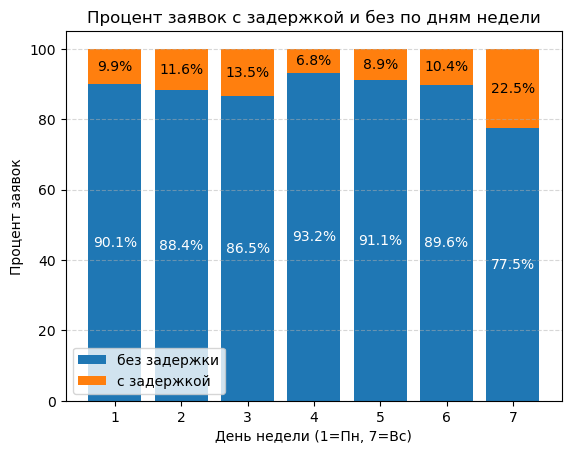

In [64]:
plt.bar(delay_percent.index, delay_percent[0], label='без задержки')
plt.bar(delay_percent.index, delay_percent[1], bottom=delay_percent[0], label='с задержкой')

for i, value in enumerate(delay_percent[0]):
    plt.text(delay_percent.index[i], y = value / 2, s=f'{value:.1f}%', ha='center', va='center', color='white')

for i, value in enumerate(delay_percent[1]):
    bottom=delay_percent[0].iloc[i]
    plt.text(delay_percent.index[i], y = bottom + value / 2, s=f'{value:.1f}%', ha='center', va='center', color='black')

plt.xlabel('День недели (1=Пн, 7=Вс)')
plt.ylabel('Процент заявок')
plt.title('Процент заявок с задержкой и без по дням недели')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## 📊 Вывод по графику: Процент заявок с задержкой поставки бетона по дням недели

Анализ распределения задержек поставок бетона по дням недели показывает **чёткую цикличность** с пиками и провалами:

* 📈 **Рост доли задержек** начинается с понедельника (9.7%) и достигает **максимума в среду** — **13.6%**.
* ✅ **Наименьший процент задержек** наблюдается в **четверг** — всего **6.7%**, что может указывать на оптимальную организацию логистики в этот день.
* 📉 После снижения в четверг доля задержек вновь начинает увеличиваться:

  * Четверг — **6.7%**
  * Пятница — **9.1%**
  * Суббота — **10.8%**
  * 📌 **Воскресенье показывает максимальную долю задержек** — **22.2%**, почти каждая **пятая заявка** поступает с отставанием от плана.
* В то же время **наивысшая надёжность доставки** — в четверг (93.3% заявок доставлены вовремя).

### 🧩 Возможные причины:

* Накопление заявок к середине недели может создавать нагрузку на поставки.
* Четверг может быть днём когда к середине недели наиболее важные заявки были уже исполнены.
* Высокая доля задержек в выходные (особенно в воскресенье) может быть связана с сокращением рабочих смен, транспорта.

---

### 📌 Рекомендации:

* Использовать **четверг как день** для ключевых заливок и поставок.
* Усилить **планирование поставок на выходные**.
* Проанализировать **нагрузку по заявкам на среду и субботу**, где задержки превышают 10%.


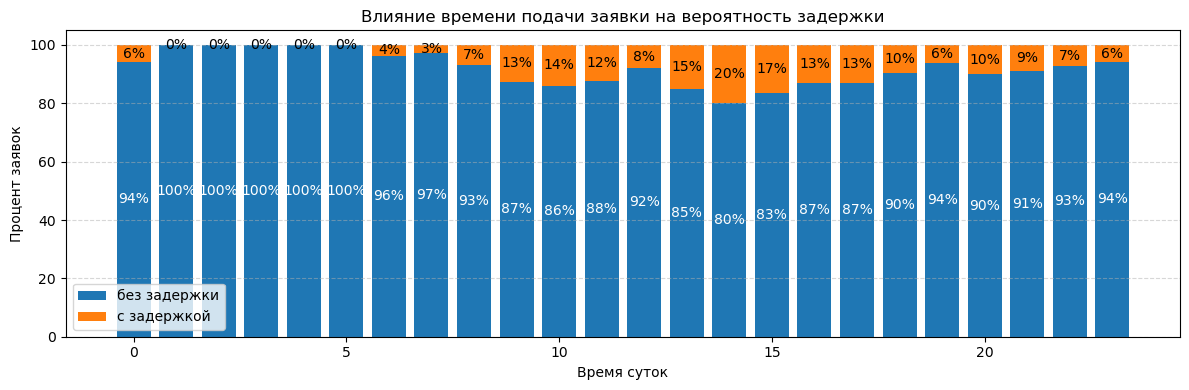

In [66]:
delay_by_time = df_ready.groupby(['application_submission_time', 'delay']).size().unstack(fill_value=0)
delay_by_time_percent = delay_by_time.div(delay_by_time.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 4))
plt.bar(delay_by_time_percent.index, delay_by_time_percent[0], label='без задержки')
plt.bar(delay_by_time_percent.index, delay_by_time_percent[1], bottom=delay_by_time_percent[0], label='с задержкой')

for i, value in enumerate(delay_by_time_percent[0]):
    plt.text(delay_by_time_percent.index[i], y = value / 2, s=f'{value:.0f}%', ha='center', va='center', color='white')

for i, value in enumerate(delay_by_time_percent[1]):
    bottom=delay_by_time_percent[0].iloc[i]
    plt.text(delay_by_time_percent.index[i], y = bottom + value / 2, s=f'{value:.0f}%', ha='center', va='center', color='black')


plt.xlabel('Время суток')
plt.ylabel('Процент заявок')
plt.ylim(0, 105)
plt.title('Влияние времени подачи заявки на вероятность задержки')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 📊 Интерпретация графика: Зависимость вероятности задержки от времени подачи заявки

### ⏰ 0–8 часов: Минимальный риск задержек (0–7%)
- **Доля заявок с задержкой:** от **0% до 7%**
- **Доля своевременных заявок:** от **93% до 100%**

💡 *Возможная причина:* эти заявки обрабатываются в первую очередь, поскольку поступают до начала рабочего дня диспетчера и попадают в его внимание в числе первых.

---

### ⚠️ 9–10 часов: Рост вероятности задержек (13–14%)
- **Доля заявок с задержкой:** **13–14%**
- **Доля своевременных заявок:** **86–87%**

💡 *Предположение:* заявки на это время подаются **в последний момент**, когда бетон нужен "на сегодня", а логистика уже загружена.

---

### 🍽 11–12 часов: Умеренное снижение задержек (12–8%)
- **Доля заявок с задержкой:** **12% в 11:00**, **8% в 12:00**
- **Доля своевременных заявок:** **88–92%**

💡 *Возможное объяснение:* заявки, поданные вблизи обеда, могут быть **обработаны в свободное время диспетчера**, снижая долю задержек.

---

### 🚨 13–14 часов: Пик задержек (15–20%)
- **Доля заявок с задержкой:** **15% в 13:00**, **20% в 14:00**
- **Доля своевременных заявок:** **85–80%**

💡 *Обоснование:* высокий процент срочных заявок, поданных ближе к середине дня, когда большая часть ресурсов уже распределена. Такие заявки **часто переносятся на следующий день**.

---

### 📉 После 15:00: Постепенное снижение задержек (16% → 6%)
- **Доля заявок с задержкой:** от **16% в 15:00** до **6% в 23:00**
- **Доля своевременных заявок:** растёт с **84% до 94%**

💡 *Интерпретация:* большинство заявок, поданных во второй половине дня, **предназначены на следующий день**, что даёт больше времени на планирование и снижает вероятность задержек.

---

### ✅ Вывод:
Наибольшая вероятность задержки наблюдается в первой половине дня, особенно **с 9 до 14 часов**.  
Минимальная вероятность — **до 8:00** и **после 18:00**, когда заявки, как правило, **планируются на будущее**, а не на текущий день.


In [68]:
df_groupby_day = pd.DataFrame(df_ready.groupby(['planned_delivery_year', 
                                                'planned_delivery_month', 
                                                'planned_delivery_day', 
                                                'planned_delivery_weekday'])['volume'].sum().reset_index())
df_mean_weekday = df_groupby_day.groupby(['planned_delivery_weekday'])['volume'].mean()
df_mean_weekday.head(50)

planned_delivery_weekday
1    183.736148
2    226.696018
3    188.024673
4    194.392453
5    162.889623
6    179.138889
7    132.150000
Name: volume, dtype: float64

In [69]:
df_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4094 entries, 0 to 4093
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   planned_delivery_time           4094 non-null   int64  
 1   type                            4094 non-null   object 
 2   material                        4094 non-null   object 
 3   volume                          4094 non-null   float64
 4   full_name                       4094 non-null   object 
 5   object                          4094 non-null   object 
 6   material_class                  4094 non-null   object 
 7   application_submission_time     4094 non-null   int64  
 8   delivery_gap_days               4094 non-null   int64  
 9   volume_by_date                  4094 non-null   float64
 10  delay                           4094 non-null   int64  
 11  planned_delivery_weekday        4094 non-null   int32  
 12  planned_delivery_year           40

In [70]:
top20_full_name = df_ready['full_name'].value_counts().head(20).reset_index()
top20_full_name_series = top20_full_name['full_name'].tolist()
df_ready['full_name'] = df_ready['full_name'].apply(lambda x: x if x in top20_full_name_series else 'другой')

In [235]:
interval_cols = df_ready.select_dtypes(include='number').columns
phik_corr = df_ready.phik_matrix(interval_cols=interval_cols)

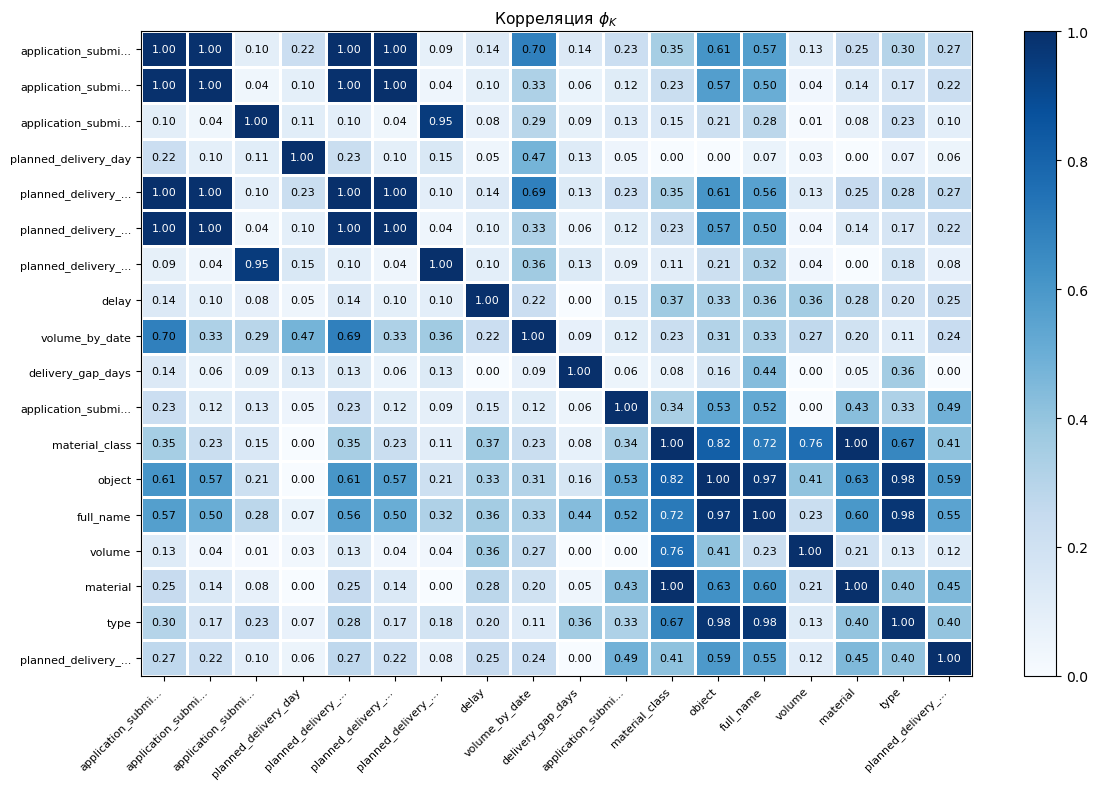

In [291]:
plot_correlation_matrix(phik_corr.values,
                        x_labels=phik_corr.columns,
                        y_labels=phik_corr.index,
                        vmin=0, vmax=1, color_map='Blues',
                        title=r'Корреляция $\phi_K$',
                        fontsize_factor=0.8,
                        figsize=(12, 8))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

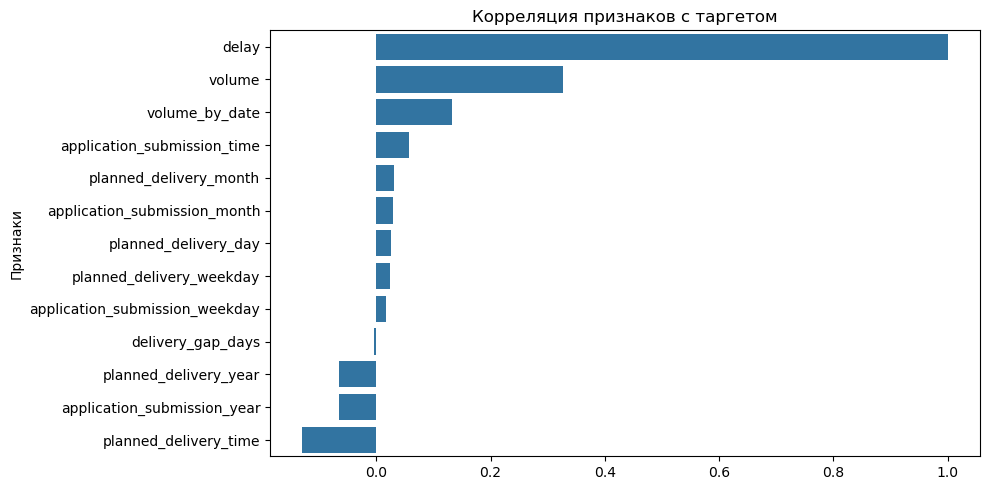

In [311]:
correlation_with_target = df_ready.corr(numeric_only=True)['delay'].sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index)
plt.title('Корреляция признаков с таргетом')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

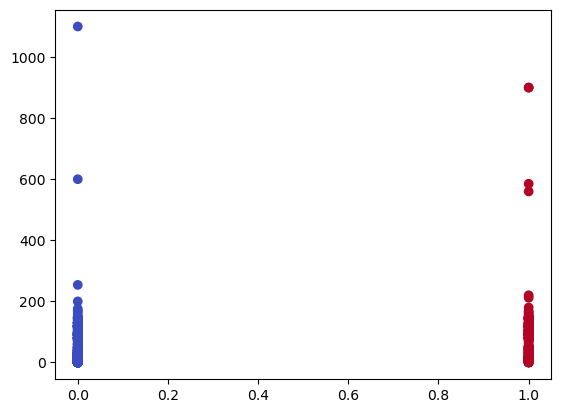

In [319]:
plt.scatter(df_ready['delay'], df_ready['volume'], c=df_ready['delay'], cmap='coolwarm')

In [201]:
X = df_ready.drop(columns= 'delay', axis=1)
y = df_ready['delay']

In [202]:
num_col = X.select_dtypes(include='number').columns
cat_col = X.select_dtypes(exclude='number').columns
print(num_col)
print(cat_col)

Index(['planned_delivery_time', 'volume', 'application_submission_time',
       'delivery_gap_days', 'volume_by_date', 'planned_delivery_weekday',
       'planned_delivery_year', 'planned_delivery_month',
       'planned_delivery_day', 'application_submission_weekday',
       'application_submission_year', 'application_submission_month'],
      dtype='object')
Index(['type', 'material', 'full_name', 'object', 'material_class'], dtype='object')


In [203]:
num_transform = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [204]:
cat_transform = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [205]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transform, num_col),
    ('cat', cat_transform, cat_col)
])

In [206]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

In [207]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3275, 17), (819, 17), (3275,), (819,))

In [208]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['planned_delivery_time', 'volume', 'application_submission_time',
       'delivery_gap_days', 'volume_by_date', 'planned_delivery_weekday',
       'planned_delivery_year', 'planned_delivery_month',
       'planned_delivery_day', 'application_submission_weekday',
       'application_submission_year', 'application_submission_month'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['type', 'material', 'full_name', 'object', 'material_class'], dtype='object'))])),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [209]:
y_pred = clf.predict(X_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [210]:
print('Accuracy - доля правильных предсказаний:', accuracy_score(y_test, y_pred))
print('Precision - сколько из предсказанных 1 действительно 1:', precision_score(y_test, y_pred))
print('Recall - сколько из настоящих 1 нашли:', recall_score(y_test, y_pred))
print('F1-score - гармония между precision и recall:', f1_score(y_test, y_pred))
print('ROC auc - общая способность модели отделять классы:', roc_auc_score(y_test, y_pred))

Accuracy - доля правильных предсказаний: 0.7936507936507936
Precision - сколько из предсказанных 1 действительно 1: 0.3073170731707317
Recall - сколько из настоящих 1 нашли: 0.7
F1-score - гармония между precision и recall: 0.4271186440677966
ROC auc - общая способность модели отделять классы: 0.7526063100137175


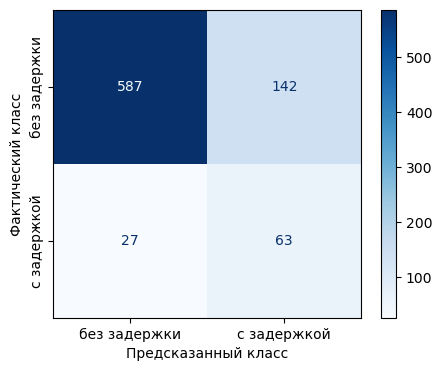

In [211]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['без задержки', 'с задержкой'])
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(cmap='Blues', ax=ax)
ax.set_ylabel('Фактический класс')
ax.set_xlabel('Предсказанный класс')
ax.set_yticklabels(['без задержки', 'с задержкой'], rotation=90, va='center')
plt.show()